In [17]:


import matplotlib.pyplot as plt
import numpy as np

In [1]:
from RecVAE.postgres_loader import PostgreSQLWrapper

pg = PostgreSQLWrapper(PARAMS)
pg.connect()

Connected to PostgreSQL database successfully.


In [3]:
query = """SELECT DISTINCT ON (steam_id,game_id) steam_id, game_id, playtime_forever, playtime_two_weeks
FROM public.played_time
ORDER BY steam_id, game_id, time_stamp DESC

                    
        """
df = pg.load_data_into_dataframe(query)
df.head()

/var/home/f0kes/dev/vae-cf-2/RecVAE/postgres_loader.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.conn)


KeyboardInterrupt: 

In [6]:
query2 = """SELECT DISTINCT ON (steam_id,game_id) steam_id, game_id, playtime_forever, playtime_two_weeks
FROM public.played_time
WHERE played_time.time_stamp <= CURRENT_TIMESTAMP - INTERVAL '1 day'
ORDER BY steam_id, game_id, time_stamp DESC
"""
df2 = pg.load_data_into_dataframe(query2)
df2.head()

/var/home/f0kes/dev/vae-cf-2/RecVAE/postgres_loader.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.conn)


,steam_id,game_id,playtime_forever,playtime_two_weeks
0,76561197960266298,250820,191617,1155
1,76561197960266298,438100,84331,1408
2,76561197960266298,553850,6008,1051
3,76561197960266298,1085660,9208,18
4,76561197960266298,1091500,270,9


In [78]:
import pandas as pd

df_game = df.groupby('game_id')['playtime_forever'].sum()
df_game_yesterday = df2.groupby('game_id')['playtime_forever'].sum()

#filter out games, with less than 60 minutes of playtime
df_game = df_game[df_game > 60]
df_game_yesterday = df_game_yesterday[df_game_yesterday > 60]
#log transform
df_game = np.log(df_game)
df_game_yesterday = np.log(df_game_yesterday)

s = df_game.std()
m = df_game.mean()
print(s)
print(m)

#filter out outliers
df_game = df_game[(df_game < m + 2 * s) & (df_game > m)]
df_game_yesterday = df_game_yesterday[(df_game_yesterday < m + 2 * s) & (df_game_yesterday > m)]

growth_rate = (df_game - df_game_yesterday) / df_game_yesterday

# Filter out games with significant growth rate
d = {'game_id': growth_rate.index, 'growth_rate': growth_rate, 'playtime_forever_now': df_game - df_game.mean(),
     'playtime_forever_yesterday': df_game_yesterday - df_game_yesterday.mean()}
# Sort fast growers by growth rate
fast_growers = pd.DataFrame(data=d)

print(len(fast_growers))
fast_growers

2.9404393601179737
8.042704680674136
13786


,game_id,growth_rate,playtime_forever_now,playtime_forever_yesterday
game_id,,,,
219,219,0.000064,-0.047457,-0.034740
410,410,0.000238,-1.709129,-1.697784
513,513,0.000000,0.028835,0.042205
640,640,0.000916,1.206792,1.209708
644,644,0.000488,1.765458,1.772983
...,...,...,...,...
2926190,2926190,0.000000,-1.944129,-1.930759
2927300,2927300,0.000000,-1.943873,-1.930503
2928150,2928150,0.000000,-1.986210,-1.972840


In [5]:
mean = df['playtime_forever'].mean()
std = df['playtime_forever'].std()

top_threshold = mean + 2 * std
bottom_threshold = mean - 2 * std

print(f"Mean: {mean}, std: {std}, top_threshold: {top_threshold}, bottom_threshold: {bottom_threshold}")

Mean: 20503.67947716041, std: 67180.10350964409, top_threshold: 154863.8864964486, bottom_threshold: -113856.52754212776


In [253]:
df_filtered = df[(df['playtime_forever'] > 60)]
df_filtered.head()


,steam_id,game_id,playtime_forever,playtime_two_weeks
0,76561197960266910,236390,13027,47
1,76561197960266910,252950,9543,12
2,76561197960266910,518790,7868,1
3,76561197960266910,635260,2884,30
4,76561197960266910,1849250,991,6


In [254]:
df_filtered['playtime_forever'].mean()

25371.325859357257

In [255]:
df_filtered['playtime_forever'].std()

74223.01394325723

In [256]:
df_time_normalized = df_filtered.copy()
df_time_normalized['playtime_forever'] = np.log(df_time_normalized['playtime_forever'])
df_time_normalized['playtime_forever'] = (df_time_normalized['playtime_forever'] - df_time_normalized[
    'playtime_forever'].min()) / (df_time_normalized['playtime_forever'].max() - df_time_normalized[
    'playtime_forever'].min())
df_time_normalized.head()

,steam_id,game_id,playtime_forever,playtime_two_weeks
0,76561197960266910,236390,0.469727,47
1,76561197960266910,252950,0.442473,12
2,76561197960266910,518790,0.425572,1
3,76561197960266910,635260,0.337682,30
4,76561197960266910,1849250,0.244136,6


In [257]:
df_time_normalized['playtime_forever'].mean()

0.34461206526444776

In [258]:
df_time_normalized['playtime_forever'].std()

0.1954087488732006

(array([5.3527e+04, 5.0017e+04, 5.1730e+04, 5.9952e+04, 5.5169e+04,
        6.4376e+04, 6.4940e+04, 6.9315e+04, 6.5680e+04, 7.2583e+04,
        7.9279e+04, 8.0970e+04, 8.4967e+04, 8.7099e+04, 8.9406e+04,
        8.5367e+04, 8.5279e+04, 8.4420e+04, 8.5334e+04, 8.3465e+04,
        8.4709e+04, 8.5488e+04, 8.5917e+04, 8.3890e+04, 8.3780e+04,
        8.4015e+04, 8.4838e+04, 8.4235e+04, 8.4921e+04, 8.4495e+04,
        8.4873e+04, 8.4535e+04, 8.5186e+04, 8.4792e+04, 8.4413e+04,
        8.3904e+04, 8.3460e+04, 8.2546e+04, 8.1354e+04, 7.9889e+04,
        8.0162e+04, 7.8001e+04, 7.6306e+04, 7.4768e+04, 7.3237e+04,
        7.2306e+04, 7.2704e+04, 7.1152e+04, 7.1122e+04, 7.0898e+04,
        7.0846e+04, 6.9640e+04, 6.9251e+04, 6.8661e+04, 6.9091e+04,
        6.7711e+04, 6.7892e+04, 6.6113e+04, 6.4103e+04, 6.2579e+04,
        6.2012e+04, 6.0596e+04, 5.8265e+04, 5.5140e+04, 5.1335e+04,
        4.7107e+04, 4.3346e+04, 3.8850e+04, 3.5051e+04, 3.1399e+04,
        2.7102e+04, 2.3001e+04, 1.9162e+04, 1.61

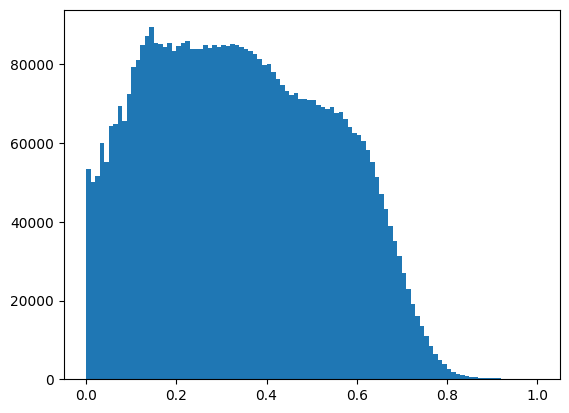

In [259]:
#plot playtime distribution
plt.hist(df_time_normalized['playtime_forever'], bins=100)

In [260]:
from pandas import DataFrame


def get_count(tp: DataFrame, id) -> DataFrame:
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [261]:
usercount, itemcount = get_count(df_time_normalized, 'steam_id'), get_count(df_time_normalized, 'game_id')
get_count(df_time_normalized, 'steam_id')

,steam_id,size
0,76561197960266910,6
1,76561197960268879,1
2,76561197960269041,2
3,76561197960269296,1
4,76561197960269822,7
...,...,...
1325815,76561199669502391,1
1325816,76561199669532308,1
1325817,76561199669551764,1
1325818,76561199669615079,1


In [262]:
def filter_triplets(tp: DataFrame, min_uc=0, min_sc=5):
    if min_sc > 0:
        itemcount = get_count(tp, 'game_id')
        tp = tp[tp['game_id'].isin(itemcount.index[itemcount >= min_sc])]

    if min_uc > 0:
        usercount = get_count(tp, 'steam_id')
        tp = tp[tp['steam_id'].isin(usercount.index[usercount >= min_uc])]

    usercount, itemcount = get_count(tp, 'steam_id'), get_count(tp, 'game_id')
    return tp, usercount, itemcount


sparsity = 1. * df_time_normalized.shape[0] / (usercount.shape[0] * itemcount.shape[0])
sparsity


0.0001113707588961643

In [263]:
game_to_idx = {game: idx for idx, game in enumerate(df_time_normalized['game_id'].unique())}
idx_to_game = {idx: game for game, idx in game_to_idx.items()}
user_to_idx = {user: idx for idx, user in enumerate(df_time_normalized['steam_id'].unique())}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

In [264]:
from numpy.linalg import svd
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

coo_df = coo_matrix((df_time_normalized['playtime_forever'],
                     (df_time_normalized['steam_id'].map(user_to_idx),
                      df_time_normalized['game_id'].map(game_to_idx))))
u, s, vt = svds(coo_df, k=50)


def cosine_similarity(item_1, item_2):
    return np.dot(item_1, item_2) / (np.linalg.norm(item_1) * np.linalg.norm(item_2))


dota_idx = game_to_idx[570]
poe_idx = game_to_idx[238960]
binding_of_isaac_idx = game_to_idx[250900]


def game_avg(game_idx):
    return np.mean([vt.T[i] for i in game_idx], axis=0)


sims = {idx_to_game[i]: cosine_similarity(game_avg([dota_idx, poe_idx, binding_of_isaac_idx]), vt.T[i]) for i in
        range(vt.T.shape[0])}


#sort by total playtime


In [274]:
total_playtime = df_time_normalized.groupby('game_id')['playtime_forever'].sum()
playtime_two_weeks = df_time_normalized.groupby('game_id')['playtime_two_weeks'].sum()
total_playtime.head()


#score is playtime in two weeks divided by total playtime multiplied by similarity
def score(game_id):
    return playtime_two_weeks[game_id] / (total_playtime[game_id] + playtime_two_weeks[game_id]) * sims[game_id]


score_df = DataFrame(
    {'game_id': list(game_to_idx.keys()), 'score': [score(game_id) for game_id in game_to_idx.keys()]})

score_df.head()
score_df = score_df.sort_values(by='score', ascending=False)
score_df.head(10)

/tmp/ipykernel_3042150/2849492559.py:8: RuntimeWarning: divide by zero encountered in log
  return np.log(playtime_two_weeks[game_id] / (total_playtime[game_id] + playtime_two_weeks[game_id])) * sims[game_id]
/tmp/ipykernel_3042150/2849492559.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.log(playtime_two_weeks[game_id] / (total_playtime[game_id] + playtime_two_weeks[game_id])) * sims[game_id]


,game_id,score
32484,566430,inf
29317,674850,inf
23910,109500,inf
2576,319750,inf
29383,308460,inf
29369,1088590,inf
29316,465780,inf
23908,699740,inf
23953,848060,inf
29436,1196440,inf


[(1452020, 0.7352170044870724),
 (2228390, 0.7209760055742536),
 (570, 0.7082692357758303),
 (1911610, 0.6966505449696614),
 (250900, 0.6965559015336797),
 (1608730, 0.6948861021471759),
 (658150, 0.6943463209628297),
 (2760480, 0.6942722697763936),
 (1311250, 0.6942452022505599),
 (2720970, 0.6929432058322816)]

game_id
7        4.400390
8        2.500549
10    6256.930703
20      33.511145
30      37.424860
Name: playtime_forever, dtype: float64